### This notebook generates the moisture-precip relationships for MCSs in the idealized RCE simulations.

In [2]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap
CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Channel images of cluster identification and saturation deficit
#### Code taken from Paul's RCE_COL_ROUGH_XR

(1, 64, 4096)


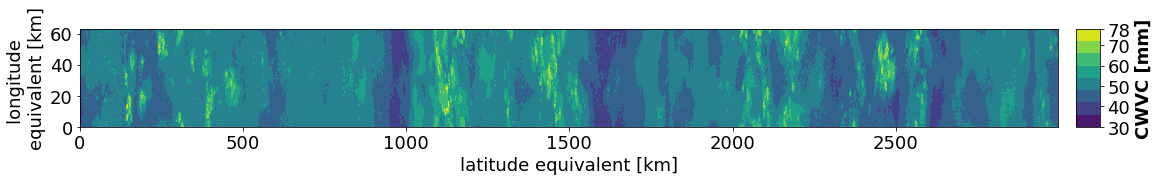

In [42]:
path = '/xdisk/sylvia/ch_cam300ri0/'
ds = xr.open_dataset( path + 'ch_cam300ri0_4096x64x64_3km_12s_cam300ri0_64_0000054000.nc' )
cwvc = ds.QV.integrate('z')*(1.3/1000)
print(cwvc_.shape )

plt.figure( figsize=(21,1.8) )
plt.contourf( cwvc[0,:,:3000] )
plt.xticks( fontsize=18 )
plt.yticks( fontsize=18 )
plt.xlabel( 'latitude equivalent [km]', fontsize=18 )
plt.ylabel( 'longitude '
           '\n'
           'equivalent [km]', fontsize=18 )
cbar = plt.colorbar( pad=0.015, aspect=4,ticks=[30,40,50,60,70,78] )
cbar.set_label( label='CWVC [mm]', size=18, weight='bold' )
cbar.ax.tick_params( labelsize=18 )
cbar.ax.set_yticklabels( ['30', '40', '50', '60', '70', '78']);

#plt.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cwvc-RCE-300K.pdf', bbox_inches='tight' )

<xarray.DataArray '__xarray_dataarray_variable__' (time: 105, y: 64, x: 4096)>
[27525120 values with dtype=int32]
Coordinates:
  * time     (time) float64 80.75 81.0 81.25 81.5 ... 106.0 106.2 106.5 106.8
  * y        (y) float32 0.0 3e+03 6e+03 9e+03 ... 1.83e+05 1.86e+05 1.89e+05
  * x        (x) float32 0.0 3e+03 6e+03 9e+03 ... 1.228e+07 1.228e+07 1.228e+07


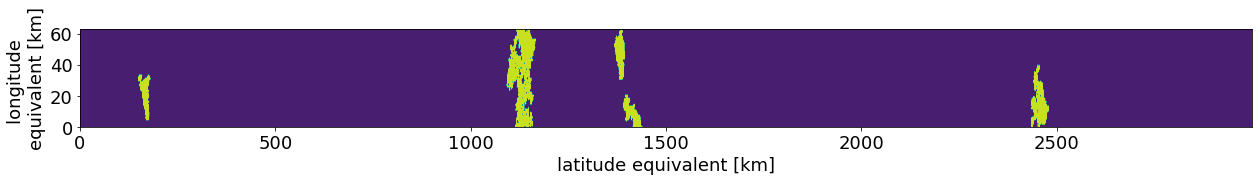

In [46]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
storms = xr.open_dataset( path + 'storms_alltime_300K_105-time-steps.nc' ).__xarray_dataarray_variable__ 
print(storms)

plt.figure( figsize=(21,1.8) )
plt.contourf( storms[30,:,:3000] )  # 30 = 54000/1800 to have the corresponding index as above
plt.xticks( fontsize=18 )
plt.yticks( fontsize=18 )
plt.xlabel( 'latitude equivalent [km]', fontsize=18 )
plt.ylabel( 'longitude '
           '\n'
           'equivalent [km]', fontsize=18 )
#cbar = plt.colorbar( pad=0.015, aspect=4 )#,ticks=[30,40,50,60,70,78] )
#cbar.set_label( label='CWVC [mm]', size=18, weight='bold' )
#cbar.ax.tick_params( labelsize=18 )
#cbar.ax.set_yticklabels( ['30', '40', '50', '60', '70', '78']);

plt.savefig( '/groups/sylvia/JAS-MCS-rain/figures/storm-id-RCE-300K.pdf', bbox_inches='tight' )

## Loading RCE data

In [47]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 280, 315, 5 )

mean_280 = xr.open_dataset( path + 'RCE_COL_MEAN_280.nc' )
mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

max_280 = xr.open_dataset( path + 'RCE_COL_MAX_280.nc' )
max_285 = xr.open_dataset( path + 'RCE_COL_MAX_285.nc' )
max_290 = xr.open_dataset( path + 'RCE_COL_MAX_290.nc' )
max_295 = xr.open_dataset( path + 'RCE_COL_MAX_295.nc' )
max_300 = xr.open_dataset( path + 'RCE_COL_MAX_300.nc' )
max_305 = xr.open_dataset( path + 'RCE_COL_MAX_305.nc' )
max_310 = xr.open_dataset( path + 'RCE_COL_MAX_310.nc' )

p95_280 = xr.open_dataset( path + 'RCE_COL_95_280.nc' )
p95_285 = xr.open_dataset( path + 'RCE_COL_95_285.nc' )
p95_290 = xr.open_dataset( path + 'RCE_COL_95_290.nc' )
p95_295 = xr.open_dataset( path + 'RCE_COL_95_295.nc' )
p95_300 = xr.open_dataset( path + 'RCE_COL_95_300.nc' )
p95_305 = xr.open_dataset( path + 'RCE_COL_95_305.nc' )
p95_310 = xr.open_dataset( path + 'RCE_COL_95_310.nc' )

p99_280 = xr.open_dataset( path + 'RCE_COL_99_280.nc' )
p99_285 = xr.open_dataset( path + 'RCE_COL_99_285.nc' )
p99_290 = xr.open_dataset( path + 'RCE_COL_99_290.nc' )
p99_295 = xr.open_dataset( path + 'RCE_COL_99_295.nc' )
p99_300 = xr.open_dataset( path + 'RCE_COL_99_300.nc' )
p99_305 = xr.open_dataset( path + 'RCE_COL_99_305.nc' )
p99_310 = xr.open_dataset( path + 'RCE_COL_99_310.nc' )

In [48]:
means = [ mean_280, mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
maxes = [ max_280, max_285, max_290, max_295, max_300, max_305, max_310 ]
p95s = [ p95_280, p95_285, p95_290, p95_295, p95_300, p95_305, p95_310 ]
p99s = [ p99_280, p99_285, p99_290, p99_295, p99_300, p99_305, p99_310 ]

data_mean = xr.combine_nested( means, concat_dim='clusters' )
data_max = xr.combine_nested( maxes, concat_dim='clusters' )
data_p95 = xr.combine_nested( p95s, concat_dim='clusters' )
data_p99 = xr.combine_nested( p99s, concat_dim='clusters' )

In [4]:
display( mean_280 )
#display( data_mean )

<xarray.Dataset>
Dimensions:   (clusters: 710, z: 64)
Coordinates:
  * clusters  (clusters) float64 7.002e+04 7.009e+04 ... 7.968e+05 7.974e+05
  * z         (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
Data variables:
    p_rate    (clusters) float64 ...
    CAPE      (clusters) float32 ...
    cwvc      (clusters) float32 ...
    csf       (clusters) float32 ...
    SD        (clusters) float32 ...
    omega     (clusters, z) float32 ...
    TABS      (clusters, z) float32 ...
    QV        (clusters, z) float32 ...
    p         (clusters, z) float32 ...

In [ ]:
raw_file = xr.open_dataset( path + 'RCE-sims/ch_cam280ri0/ch_cam280ri0_4096x64x64_3km_12s_cam280ri0_64_0000023400.nc' )
display( raw_file )

## Figure 4 - Joint distribution of CSF and MCS precip

In [5]:
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=12)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=12)
    ax_histy.set_yscale('log')
    return h

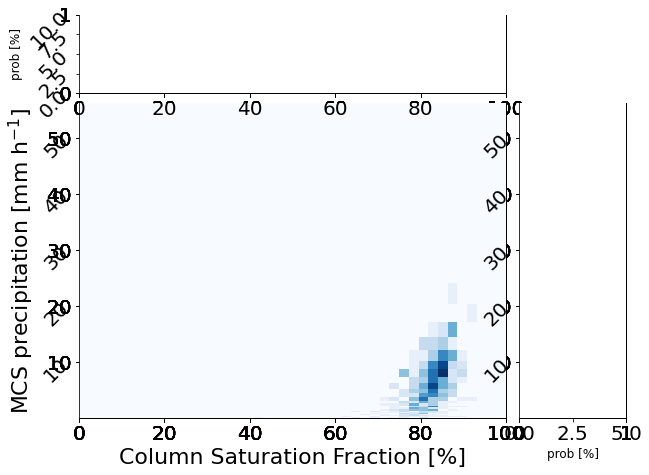

In [8]:
fig = plt.figure( figsize=(9.5, 7) )
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for file in means:
    csf_RCE = file.csf
    pmean_RCE = file.p_rate
    i = np.where( (~np.isnan(csf_RCE)) & (~np.isnan(pmean_RCE)) )

    gs = fig.add_gridspec( 2, 2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
    ax = fig.add_subplot(gs[1,0])
    ax_histx = fig.add_subplot( gs[0,0], sharex=ax )
    ax_histy = fig.add_subplot( gs[1,1], sharey=ax )
    xbins = np.linspace( 0, 100, 45 )
    ybins = np.logspace( -1.5, 1.75, 45 )
    h = ax.hist2d( csf_RCE[i]*100, pmean_RCE[i], bins=(xbins, ybins), cmap=cm.Blues )
    #h = scatter_hist( csf_RCE[i]*100, pmean_RCE[i], xbins, ybins, ax, ax_histx, ax_histy )

ax.set_xticks( [0, 20, 40, 60, 80] )
ax_histx.set_ylabel( 'prob [%]', fontsize=12 )
ax_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax_histy.set_xlabel( 'prob [%]', fontsize=12 )
ax_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax.set_ylabel( 'MCS precipitation [mm h$^{-1}$]' )
ax.set_xlabel( 'Column Saturation Fraction [%]' )

for a in ax, ax_histx, ax_histy:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)
        
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI.pdf', bbox_inches='tight' )
plt.show()

## Figure 5 - CSF-precip relationship for MCS across percentiles

In [7]:
mean_RCE = [ mean_280 , mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
max_RCE = [ max_280 , max_285, max_290, max_295, max_300, max_305, max_310 ]
yy = max_RCE # mean_RCE
cwvc_bins_list = [ [] for i in np.arange( len(yy) ) ]
csf_bins_list = [ [] for i in np.arange( len(yy) ) ]

pmean_list = [ [] for i in np.arange( len(yy) ) ]
p95_list = [ [] for i in np.arange( len(yy) ) ]
p99_list = [ [] for i in np.arange( len(yy) ) ]
pmax_list = [ [] for i in np.arange( len(yy) ) ]

pmean_list2 = [ [] for i in np.arange( len(yy) ) ]
p95_list2 = [ [] for i in np.arange( len(yy) ) ]
p99_list2 = [ [] for i in np.arange( len(yy) ) ]
pmax_list2 = [ [] for i in np.arange( len(yy) ) ]

cwvc_error_list = [ [] for i in np.arange( len(yy) ) ]
csf_error_list = [ [] for i in np.arange( len(yy) ) ]
perror_list = [ [] for i in np.arange( len(yy) ) ]
perror_list2 = [ [] for i in np.arange( len(yy) ) ]

In [8]:
for iterator, array in enumerate( yy ):
    csf_RCE = array['csf'].to_numpy()
    cwvc_RCE = array['cwvc'].to_numpy()
    pmean_RCE = array['p_rate'].to_numpy()
    cwvc_min = np.nanmin( cwvc_RCE )
    cwvc_max = np.nanmax( cwvc_RCE )

    cwvc_bins, pmean_vals, p95_vals, p99_vals, cwvc_error, p_error, cwvc_max, pmax = \
        bin_stat_function( 15, cwvc_min, cwvc_max, cwvc_RCE, pmean_RCE, threshold=10 )
    
    cwvc_bins_list[iterator] = cwvc_bins
    pmean_list[iterator] = pmean_vals
    p95_list[iterator] = p95_vals
    p99_list[iterator] = p99_vals
    pmax_list[iterator] = pmax
    
    cwvc_error_list[iterator] = cwvc_error
    perror_list[iterator] = p_error
    
    csf_bins, pmean_vals2, p95_vals2, p99_vals2, csf_error, p_error2, csf_max, pmax2 = \
        bin_stat_function( 15, 0, 100, csf_RCE, pmean_RCE, threshold=10 )
    
    csf_bins_list[iterator] = csf_bins
    pmean_list2[iterator] = pmean_vals2
    p95_list2[iterator] = p95_vals2
    p99_list2[iterator] = p99_vals2
    pmax_list2[iterator] = pmax2
    
    csf_error_list[iterator] = csf_error
    perror_list2[iterator] = p_error2

In [20]:
print( cwvc_bins_list[0] )
print( pmax_list[0] )

[        nan         nan         nan 10.349576   10.54928398 10.77371693
 10.99358273 11.20894718 11.43280411 11.6461935  11.86628246 12.06153202
         nan         nan         nan]
[[        nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan]
 [23.97439093 24.26178334 25.62728967 27.59977151 33.82950579]
 [25.23903782 27.69710217 29.79481383 33.08178973 43.24070038]
 [31.4592775  31.83913068 32.35133202 33.70734164 38.33320085]
 [32.93067869 33.57289592 34.10386224 34.57246302 37.56789956]
 [35.91187438 37.46761847 38.60448115 41.28046241 45.8328207 ]
 [42.89725609 42.98423929 44.91130169 45.14467064 46.64700944]
 [38.63352863 39.30060659 40.51820375 40.95303174 43.02956024]
 [36.98849631 38.942385   39.43178337 39.59667217 40.94002722]
 [37.02124022 38.33255963 39.34033681 41.53730907 46.79678567]
 [        nan         nan         nan         nan         na

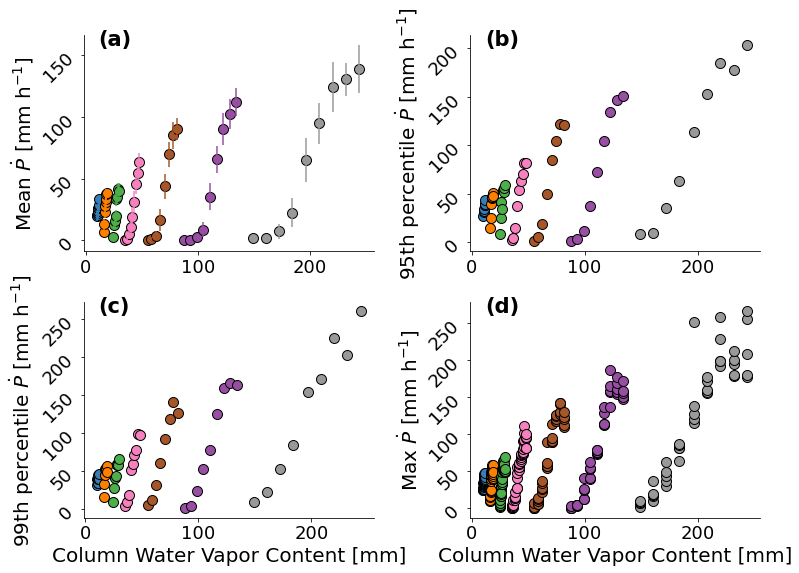

In [30]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 8) )

ylab = [ r'Mean $\dot{P}$ [mm h$^{-1}$]', r'95th percentile $\dot{P}$ [mm h$^{-1}$]', r'99th percentile $\dot{P}$ [mm h$^{-1}$]',\
             r'Max $\dot{P}$ [mm h$^{-1}$]' ]
labels = [ '', '' , 'Column Water Vapor Content [mm]', 'Column Water Vapor Content [mm]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    #axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        for j, k, l, m, n in zip(cwvc_bins_list, pmean_list, np.arange(len(cwvc_bins_list)), cwvc_error_list, perror_list):
            axis.scatter( j, k, color = CB_color_cycle[l], s=100, edgecolor='black'  )
            axis.errorbar( j, k, xerr=m/2, yerr=n/2, color = CB_color_cycle[l], ls='none' )
    elif i == 1:
        for j, k, l in zip(cwvc_bins_list, p95_list, np.arange(len(cwvc_bins_list))):
            axis.scatter( j, k, color = CB_color_cycle[l], s=100, edgecolor='black' )
    elif i == 3:
        for j, k, l in zip(cwvc_bins_list, pmax_list, np.arange(len(cwvc_bins_list))):
            for m, n in zip(j, k):
                if ~np.isnan(m):
                    axis.scatter( [m]*len(n), n, color = CB_color_cycle[l], s=100, edgecolor='black' )
    else:
        for j, k, l in zip(cwvc_bins_list, p99_list, np.arange(len(cwvc_bins_list))):
            axis.scatter( j, k, color = CB_color_cycle[l], s=100, edgecolor='black' )
            
plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cwvc-precip-RCE.pdf', bbox_inches='tight' )
plt.show()

## Figure 6 - Saturation deficit-CAPE relationship across percentiles

## Figure 9 - Pressure velocity-CAPE conversion

## Figure 12 - precip efficiency from integrated cond rate scaling